## Particle within radius or overlap calculations

In [6]:
#dataframes
import pandas as pd
import h5py

#suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.TimeSeries = pd.Series 

#math
import numpy as np
import math as m
from scipy.spatial.distance import cdist
from scipy.stats import binned_statistic_2d as bsd

#plots
import pylab as plt
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable # for colorbar
import seaborn as sns
import figurefirst
sns.set()
sns.set_style("whitegrid", {'axes.grid' : False})

#misc
import time
np.set_printoptions(suppress=True)

In [11]:
def get_particle_statistics(x,y,wind_speed):
    x,y= np.array([x,y]).astype(int)
    if (wind_speed <= 3):
        log_whiff = LW1[y][x]
        ef = LW2[y][x]
        ma = LW3[y][x]
        return log_whiff, ef, ma
    else:
        log_whiff = HW1[y][x]
        ef = HW2[y][x]
        ma = HW3[y][x]
        return log_whiff, ef, ma
        

In [8]:
def condition_plot(ax):
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.xaxis.set_major_locator(plt.MaxNLocator(3))
    ax.yaxis.set_major_locator(plt.MaxNLocator(3))
def remove_tick_labels(ax):
    ax.spines['left'].set_visible(False)
    ax.tick_params(left=False, labelleft=False)

In [9]:
dir = '~/Documents/Myfiles/DataAnalysis/data/Sprints/HighRes/'
df = pd.read_hdf(dir+'NotWindy/HWStats.h5')

In [15]:
x = np.linspace(0,40,41)
y = np.linspace(0,25,26)

## Whiff Duration
LW1 , x1, y1, binno1 = bsd(df.avg_dist_from_source, df.avg_dist_from_streakline, df.log_whiff, 
                       statistic = 'mean', bins=(x,y), expand_binnumbers=True)
## Encounter Frequency
LW2 , x2, y2, binno2 = bsd(df.avg_dist_from_source, df.avg_dist_from_streakline, df.mean_encounter_frequency, 
                       statistic = 'mean', bins=(x,y), expand_binnumbers=True)
## Moving Avg
LW3 , x3, y3, binno3 = bsd(df.avg_dist_from_source, df.avg_dist_from_streakline, df.mean_ma, 
                       statistic = 'mean', bins=(x,y), expand_binnumbers=True)


LW1 = LW1.T
# LW1[np.isnan(LW1)] = 0
LW2 = LW2.T
# LW2[np.isnan(LW2)] = 0
LW3 = LW3.T
# LW3[np.isnan(LW3)] = 0

In [14]:
get_particle_statistics(0,0,2)

(-0.9772789057803518, 2.0433124578276765, 60.722254638716414)

In [123]:
## test
# idx = np.where((df.avg_dist_from_source >=3)& (df.avg_dist_from_source<=4) & 
#               (df.avg_dist_from_streakline>=0) & (df.avg_dist_from_streakline <=1)) 
# np.mean(df.log_whiff.loc[idx])

# x,y= np.array([3,0]).astype(int)
# LW1[y][x]

-1.6854774437205198

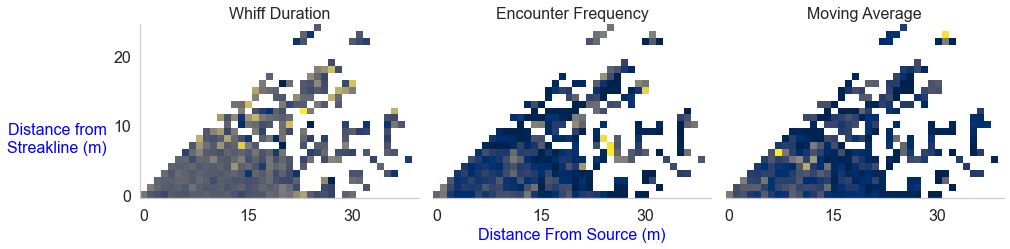

In [16]:
f, (ax1,ax2,ax3) = plt.subplots(1,3, figsize =(14,10))
extent=[x1[0], x1[-1], y1[0], y1[-1]]

ax1.imshow(LW1, interpolation='nearest', origin='lower',cmap = 'cividis')
ax2.imshow(LW2, interpolation='nearest', origin='lower',cmap = 'cividis')
ax3.imshow(LW3, interpolation='nearest', origin='lower',cmap = 'cividis')

ax1.set_ylabel('Distance from\nStreakline (m)' , fontsize = 13, rotation = 0, color = 'blue')
ax1.title.set_text('Whiff Duration')
ax1.yaxis.set_label_coords(-0.3, 0.25)
ax2.set_xlabel('Distance From Source (m)' , fontsize = 13, color='blue')
ax2.title.set_text('Encounter Frequency')
ax3.title.set_text('Moving Average')

condition_plot(ax1)
condition_plot(ax2)
remove_tick_labels(ax2)
condition_plot(ax3)
remove_tick_labels(ax3)

figurefirst.mpl_functions.set_fontsize(f, 16)
f.tight_layout()

f.savefig('../../Figure/OS_LW.jpeg') 